In [53]:
import matplotlib.pyplot as plt
!pip install simpy
import simpy
import random
import statistics
import scipy as sc
import numpy as np
import random
import pandas as pd

In [23]:

import random
import statistics
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
mu = 4
rho = 0.5
p0 = (1 + rho*((1 - (rho/2)**4) / (1 - rho/2)))**(-1)
def prob(k):
    res = rho**k * p0 / 2**(k-1)
    return res
prob_list = []
prob_list.append(p0)
for i in range(1, 5):
    prob_list.append(prob(i))

In [3]:
print(p0)

0.6009389671361502


In [ ]:
plt.bar(['S{}'.format(i) for i in range(5)], prob_list)
plt.title('Распределение вероятностей состояний СМО')
plt.show()

In [4]:
p_rej = prob_list[4]
p_rej
p_rej2 = ((1/2)**4 * 0.6)/8
print(p_rej)
print(p_rej2)

0.004694835680751174
0.0046875


In [5]:
1.2 #Относительная пропускная способность
q = 1 - p_rej
q

0.9953051643192489

In [6]:
1.1 #абсолютную пропускную способность
lambd = 2
a = lambd * q
a

1.9906103286384977

2.7 среднее число заявок в очереди
𝐿оч=𝔼(𝑘)=0⋅(𝑝0+𝑝1+𝑝2)+1⋅𝑝3+2⋅𝑝4 где 𝑘 — случайная величина количества заявок в очереди

In [7]:
l = 1*prob_list[3] + 2*prob_list[4]
l

0.028169014084507043

2.1 Среднее время ожидания заявки в очереди по формуле Литтла
$$\overline{T}_\text{оч} = \frac{L_{оч}}{\lambda}$$

In [8]:
t = l / lambd
t

0.014084507042253521

1.3 Средняя продолжительность периода занятости СМО
$$E_s = (1 - p_0) / lambda * p_0$$

In [9]:
odintri = (1 - prob_list[0])/(lambd * prob_list[0])
print(odintri)

0.33203125


1.4 коэффициент использования СМО
$$K_{исп} = 1 - p_0$$

In [10]:
k_use = 1 - prob_list[0]
print(k_use)
k_use2 = odintri / (1/lambd + odintri)
print(k_use2)

0.39906103286384975
0.39906103286384975


2.8 среднее число заявок в СМО
$$ L_{СМО} = p_0 \cdot 0 + p_1 \cdot 1 + p_2 \cdot 2 + \dots + p_6 \cdot 6$$

In [12]:
l_cmo = 0
for i in range(1, 5):
    l_cmo += i * prob_list[i]
l_cmo

0.5258215962441315

2.2 среднее время пребывания заявки в СМО.

In [13]:
t_proc3 = l_cmo/lambd
t_proc3

0.26291079812206575

2.4 вероятность немедленного приема к обслуживанию.

Найдем вероятность нахождения системы в состоянии хотя бы одного свободного канала, то есть $S_1$ или $S_2$
$$P_{обсл} = p_0 + p_1$$

In [14]:
p_serve = prob_list[0] + prob_list[1]
p_serve

0.9014084507042254

СИМУЛЯЦИИ

In [15]:
class System:
    def __init__(self, env, num_ser):
        self.env = env
        self.loader = simpy.Resource(env, num_ser)

    def app_processing(self, application, mu):
        yield self.env.timeout(np.random.exponential(scale=1 / mu))

In [36]:
def get_application(env, application, system, queue_length, mu, total_spent_times, mean_total_spent_times_hist,
                queue_times, reject_applicatons, total_applications, prob_reject_hist, queue_time_hist, empty_server, ready_for_immediate_processing, p_zero_hist, p_immediate):
    # заявка приходит в систему
    arrival_time = env.now
    if len(system.loader.users) + len(system.loader.queue) == 0: # проверяем, есть ли в системе заявки
                empty_server.append(application)

    if len(system.loader.users) + len(system.loader.queue) < system.loader.capacity : # проверяем, есть ли в системе заявки
                ready_for_immediate_processing.append(application)

    with system.loader.request() as request:
        if len(system.loader.users) + len(system.loader.queue) <= queue_length + system.loader.capacity: # выполняем проверку, уйдет ли заявка в отказ
            start_queue_time = env.now # момент попадания в очередь
            yield request
            queue_times.append(env.now - start_queue_time) # старт обслуживания, подсчет времени ожидания в очереди
            yield env.process(system.app_processing(application, mu))
        else:
            queue_times.append(0) # в случае переполненности время ожидания = 0
            system.loader.release(request) # отказ
            reject_applicatons.append(application)

    # заявка покидает базу  -> считаем показатели СМО
    total_applications.append(application) # количество заявок
    prob_reject_hist.append(len(reject_applicatons) / len(total_applications)) # доля отклонённых заявок
    p_zero_hist.append(len(empty_server) / len(total_applications)) # доля случаев, когда система пустует
    p_immediate.append(len(ready_for_immediate_processing) / len(total_applications)) # доля случаев, когда система готова мгновенно приступить к обработке заявки
    queue_time_hist.append(np.mean(queue_times)) # среднее время ожидания в очереди
    total_spent_times.append(env.now - arrival_time) # общее время, проведённое заявкой в системе
    mean_total_spent_times_hist.append(np.mean(total_spent_times)) # среднее общее время, проведённое заявкой в системе

#генерация приходящих заявок
def run_server(env, num_ser, queue_length, mu, lambda_, total_spent_times, mean_total_spent_times_hist,
                   queue_times, reject_applicatons, total_applications, prob_reject_hist, queue_time_hist, empty_server, ready_for_immediate_processing, p_zero_hist, p_immediate):
    system = System(env, num_ser)
    application = -1
    while True:
        yield env.timeout(np.random.exponential(scale=1 / lambda_))  # заявки приходят через эксп. распр. моменты
                                                                   # с параметром лямбда
        application += 1
        env.process(get_application(env, application, system, queue_length, mu, total_spent_times, mean_total_spent_times_hist,
                                queue_times, reject_applicatons, total_applications, prob_reject_hist, queue_time_hist, empty_server, ready_for_immediate_processing, p_zero_hist, p_immediate))

def simulations(N, T):
    prob_rej_hist_lst, queue_time_hist_lst, mean_total_spent_times_hist_lst, p_zero_hist_lst, p_immediate_lst = [], [], [], [], []
    for _ in range(N):
        random.seed(42) # фиксируем seed

        lambda_ = 2 # интенсивность входного потока
        mu = 4 # интенсивность обслуживания
        n = 2 # число каналов
        c = 2 # число мест в очереди
        total_spent_times = [] # время пребывания заявки в СМО
        mean_total_spent_times_hist = [] # история среднего времени пребывания заявки в СМО
        queue_times = [] # время пребывания заявки в очереди
        reject_applicatons = [] # число заявок с отказом (закидываем в этот список сами завки, берем его длину)
        total_applications = [] # общее число заявок
        prob_reject_hist = [] # история наблюдаемых значений вероятности отказа
        queue_time_hist = [] # история наблюдаемых значений среднего времени пребывания в очереди
        empty_server = [] # число заявок, заставших ноль заявок при попадании в СМО
        ready_for_immediate_processing = [] # число заявок, готовых к немедленной обработке
        p_zero_hist = [] # история наблюдаемых значений pi_0
        p_immediate = [] # история наблюдаемых значений pi_0+pi_1

        env = simpy.Environment() # симуляция
        proc = env.process(run_server(env, n, c, mu, lambda_,
                                          total_spent_times, mean_total_spent_times_hist,
                                          queue_times, reject_applicatons, total_applications, prob_reject_hist,
                                          queue_time_hist, empty_server, ready_for_immediate_processing, p_zero_hist, p_immediate))
        env.run(until=T) # модельное время
        prob_rej_hist_lst.append(prob_reject_hist)
        queue_time_hist_lst.append(queue_time_hist)
        mean_total_spent_times_hist_lst.append(mean_total_spent_times_hist)
        p_zero_hist_lst.append(p_zero_hist)
        p_immediate_lst.append(p_immediate)
    return prob_rej_hist_lst, queue_time_hist_lst, mean_total_spent_times_hist_lst, p_zero_hist_lst, p_immediate_lst

#запускаем
prob_rej_hist_lst, queue_time_hist_lst, mean_total_spent_times_hist_lst, p_zero_hist_lst, p_immediate_lst = simulations(N=100, T=1000)

In [37]:
def plt_func(name, value, theor_value, gap_perc=0.05, ylim=False):
    gap = theor_value * gap_perc # считаем процентное отклонение от теоретического значения
    %config InlineBackend.figure_format = 'retina'
    fig, axs = plt.subplots(2,1, figsize=(15, 16))
    axs[0].set_ylabel(name)
    axs[1].set_ylabel('Разница')
    axs[0].set_xlabel('После k-ой обработанной заявки за 2000 часов')
    axs[0].set_title('{} для разных симуляций'.format(name))
    axs[1].set_title('Разница между теоретическим и наблюдаемым')
    axs[0].grid()
    axs[1].grid()
    if ylim:
        axs[0].set_ylim(0, ylim)
    for elem in value:
        axs[0].plot(elem)
        difer = np.abs(np.array(elem) - theor_value * np.ones(len(elem)))
        #axs[1].set_ylim(0, 0.05)
        axs[1].plot(difer)
    axs[0].axhline(y=theor_value, color='r', linestyle='--', label='Теоретическое значение')
    if gap:
        axs[0].axhline(y=theor_value + gap, color='r', linestyle='-')
        axs[0].axhline(y=theor_value - gap, color='r', linestyle='-')
    print(difer)

[0.39907    0.39907    0.06573667 ... 0.00619468 0.00639452 0.00659415]


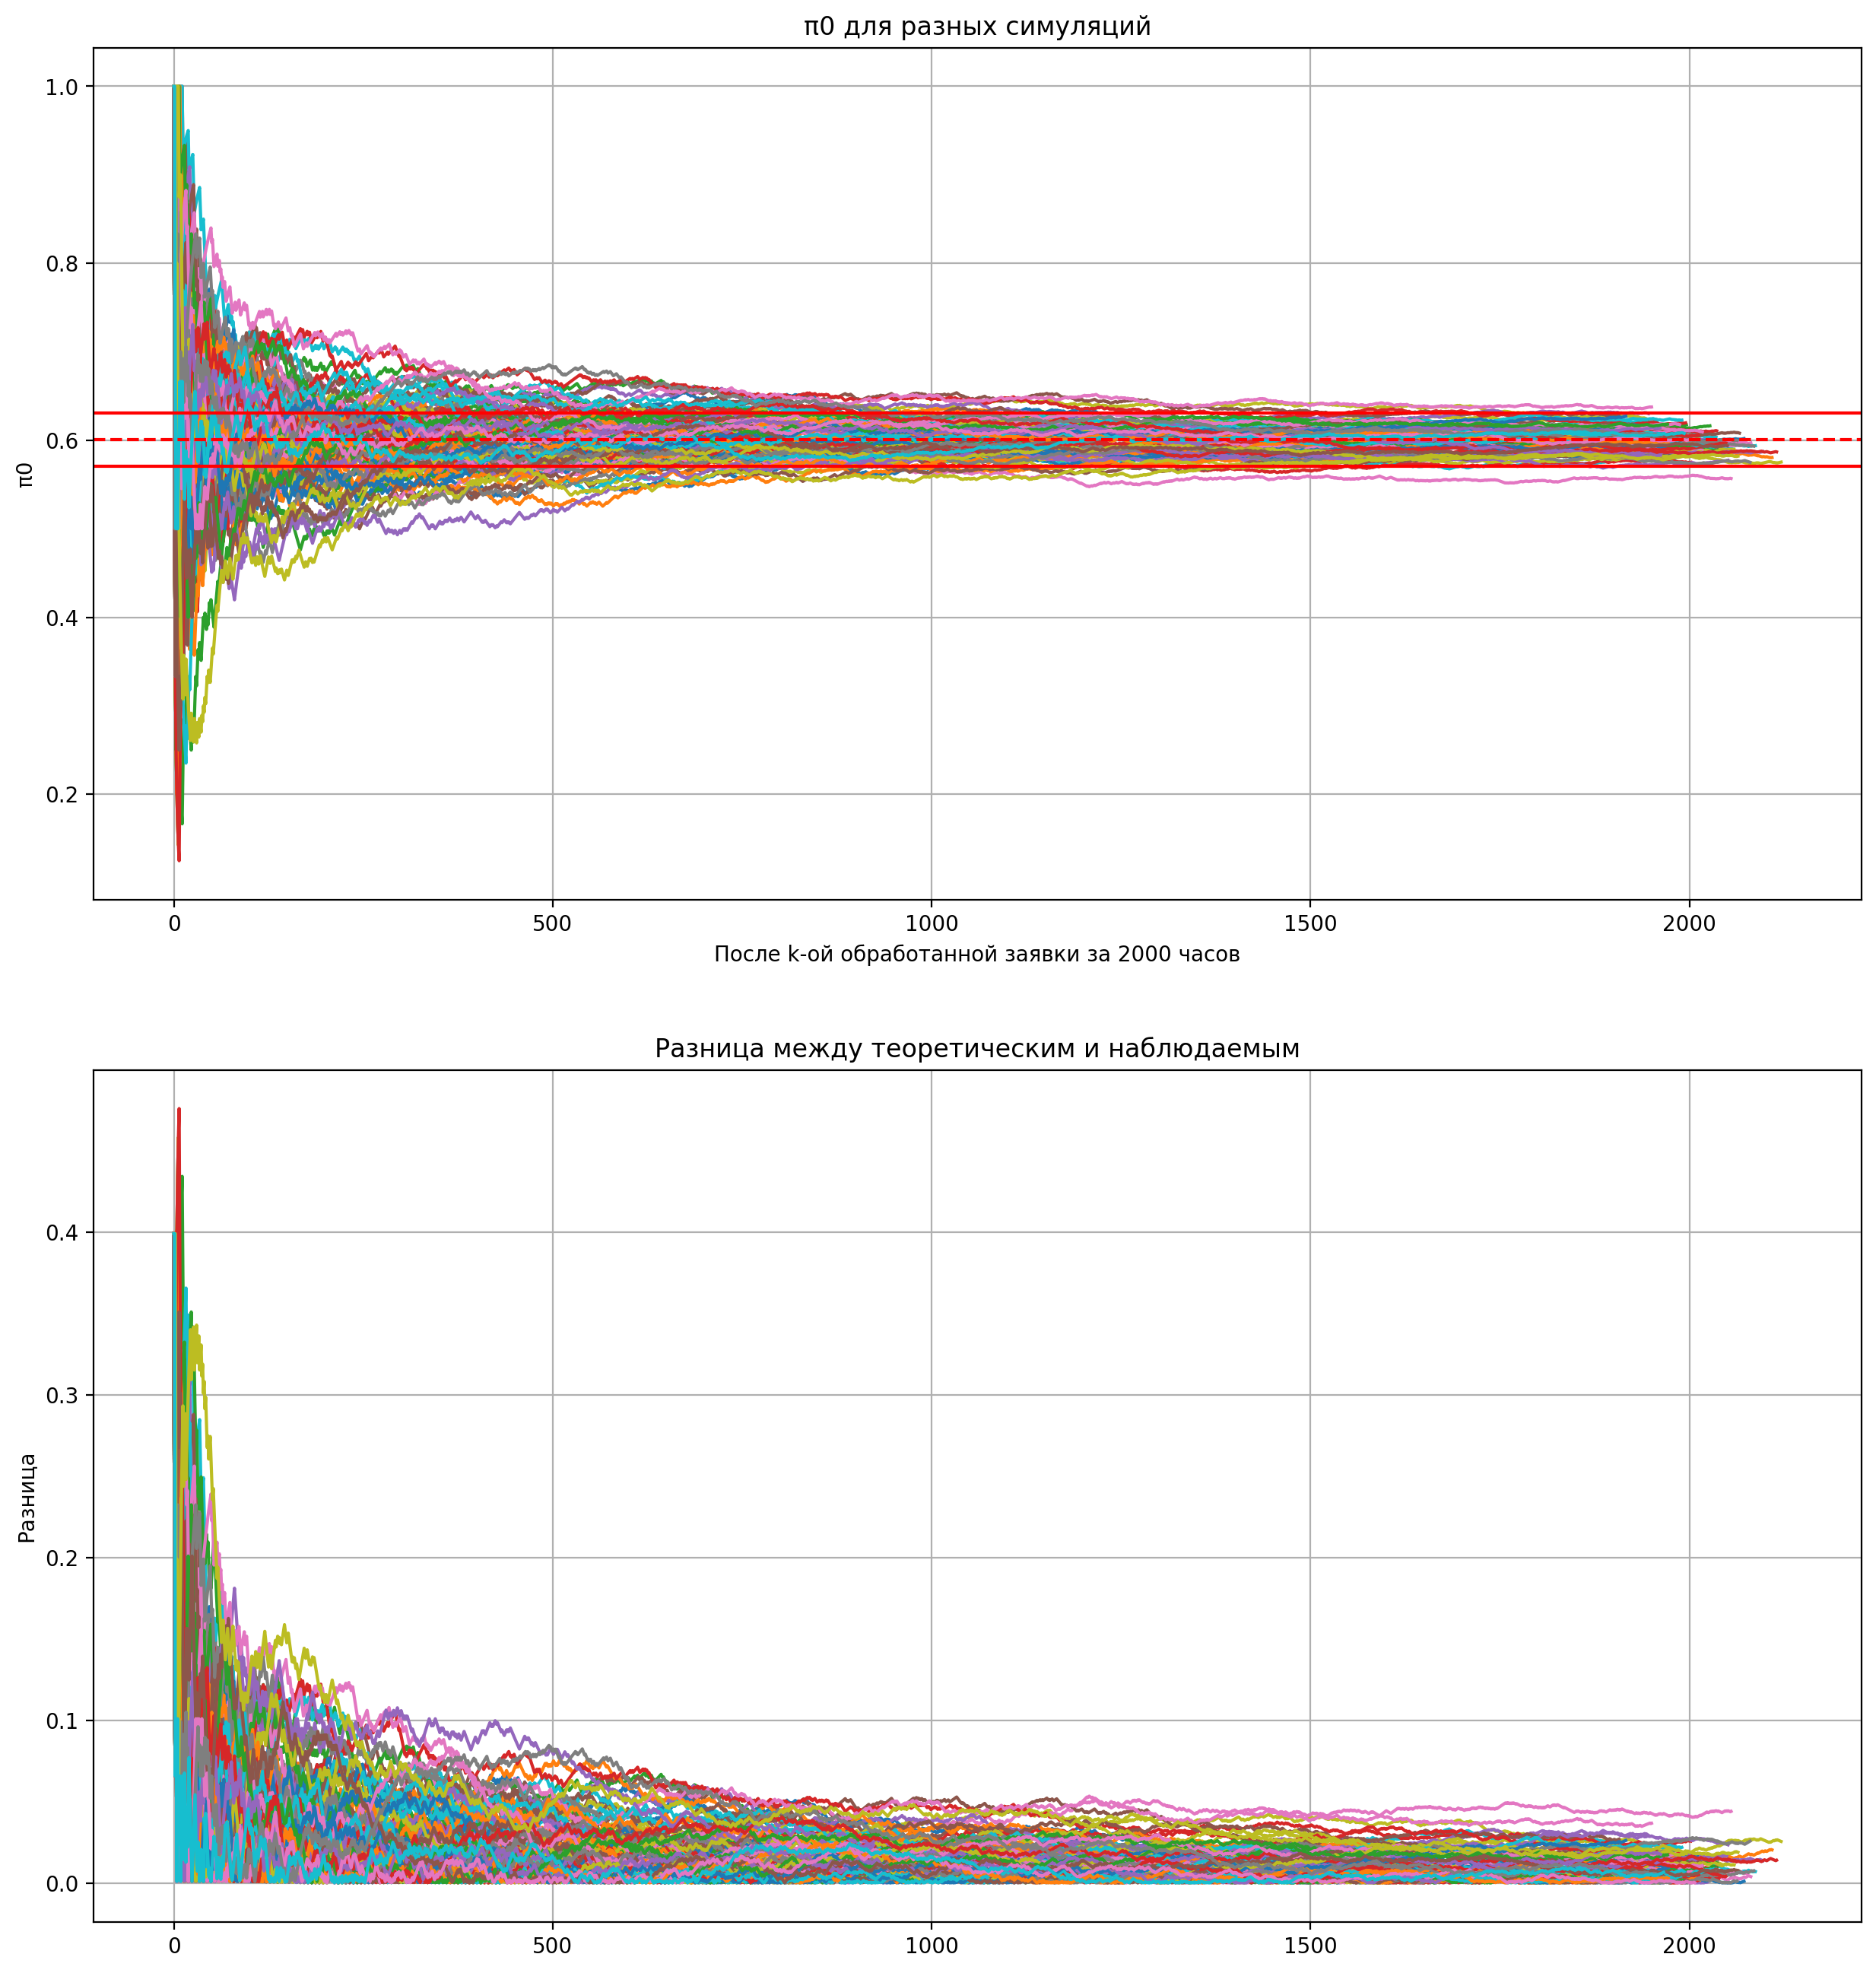

In [38]:
plt_func('π0', p_zero_hist_lst, 0.60093)

Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка


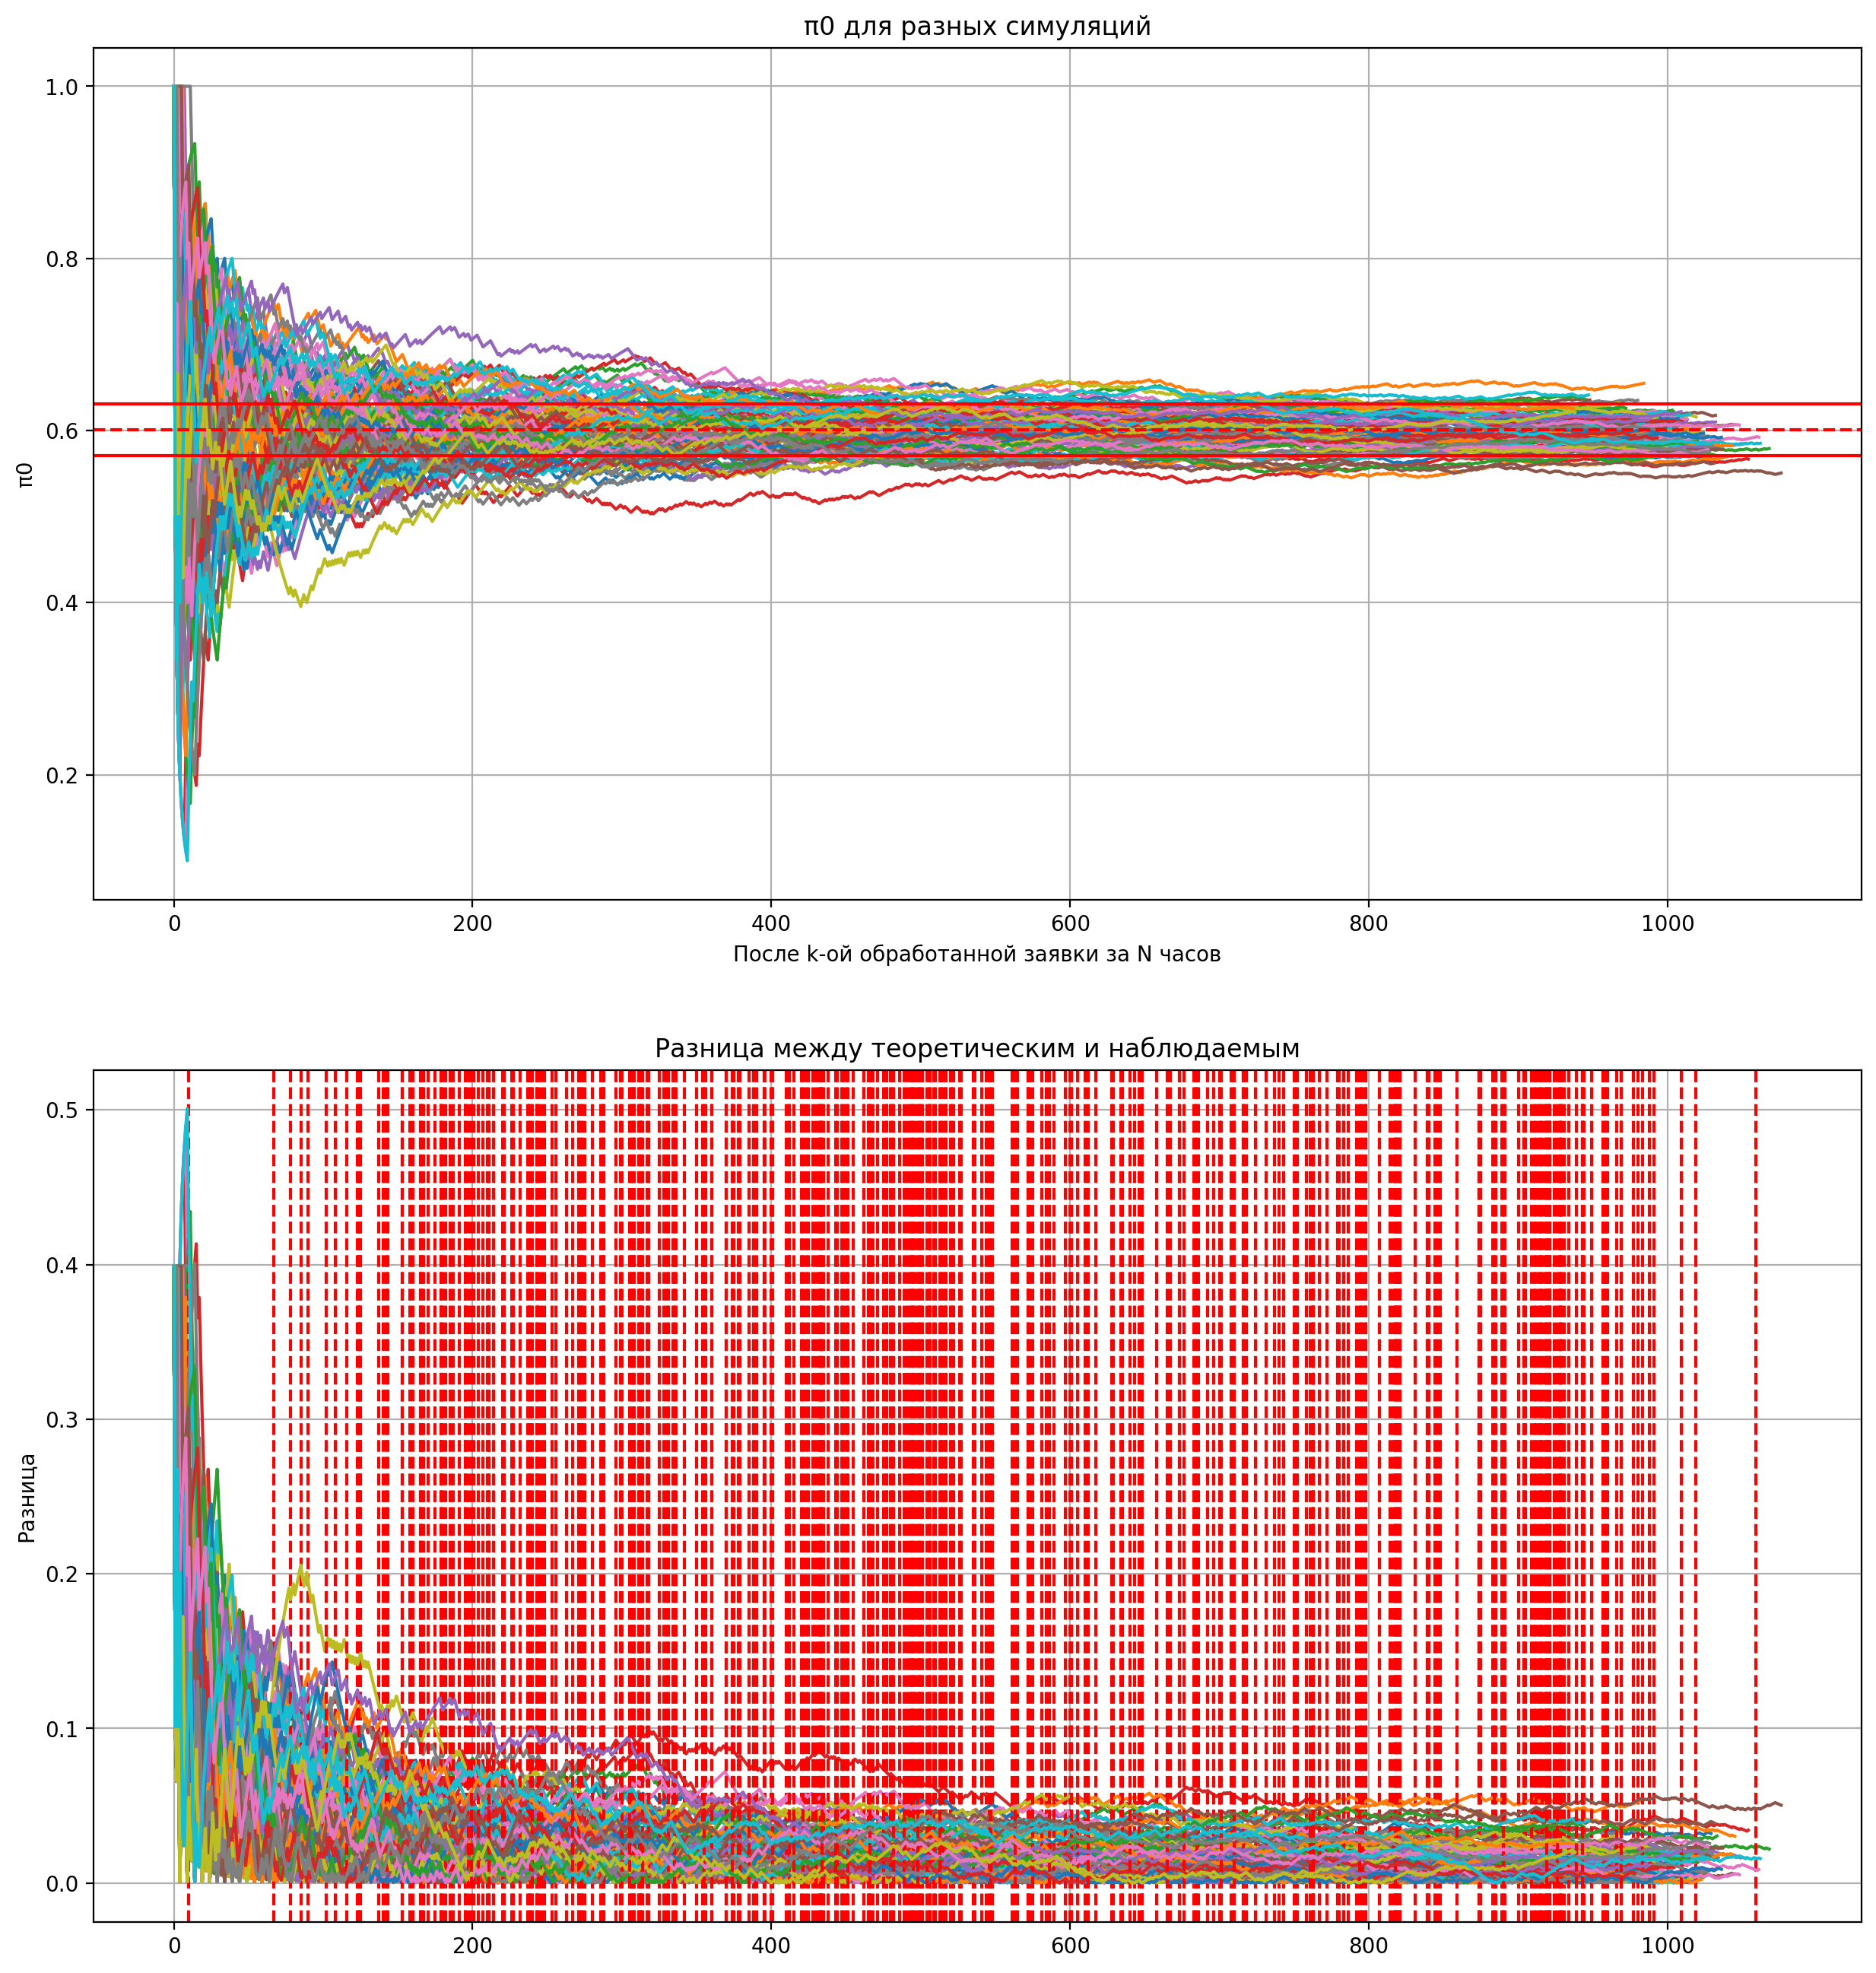

In [42]:
def plt_func(name, value, theor_value, gap_perc=0.05, ylim=False):
    gap = theor_value * gap_perc # считаем процентное отклонение от теоретического значения
    %config InlineBackend.figure_format = 'retina'
    fig, axs = plt.subplots(2,1, figsize=(15, 16))
    axs[0].set_ylabel(name)
    axs[1].set_ylabel('Разница')
    axs[0].set_xlabel('После k-ой обработанной заявки за N часов')
    axs[0].set_title('{} для разных симуляций'.format(name))
    axs[1].set_title('Разница между теоретическим и наблюдаемым')
    axs[0].grid()
    axs[1].grid()
    if ylim:
        axs[0].set_ylim(0, ylim)
    stop = False
    for elem in value:
      axs[0].plot(elem)
      difer = np.abs(np.array(elem) - theor_value * np.ones(len(elem)))
      count = 0
      for i in range(1, len(difer)):
          if np.abs(difer[i] - difer[i-1]) < 0.05*difer[i-1]:
              count += 1
          else:
              count = 0
          if count == 10:
              print("Остановка")
              axs[1].axvline(x=i, color='r', linestyle='--')
      axs[1].plot(difer)
    axs[0].axhline(y=theor_value, color='r', linestyle='--', label='Теоретическое значение')
    if gap:
        axs[0].axhline(y=theor_value + gap, color='r', linestyle='-')
        axs[0].axhline(y=theor_value - gap, color='r', linestyle='-')
plt_func('π0', p_zero_hist_lst, 0.60093)


In [44]:
prob_rej_hist_lst, queue_time_hist_lst, mean_total_spent_times_hist_lst, p_zero_hist_lst, p_immediate_lst = simulations(N=100, T=500)

Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка


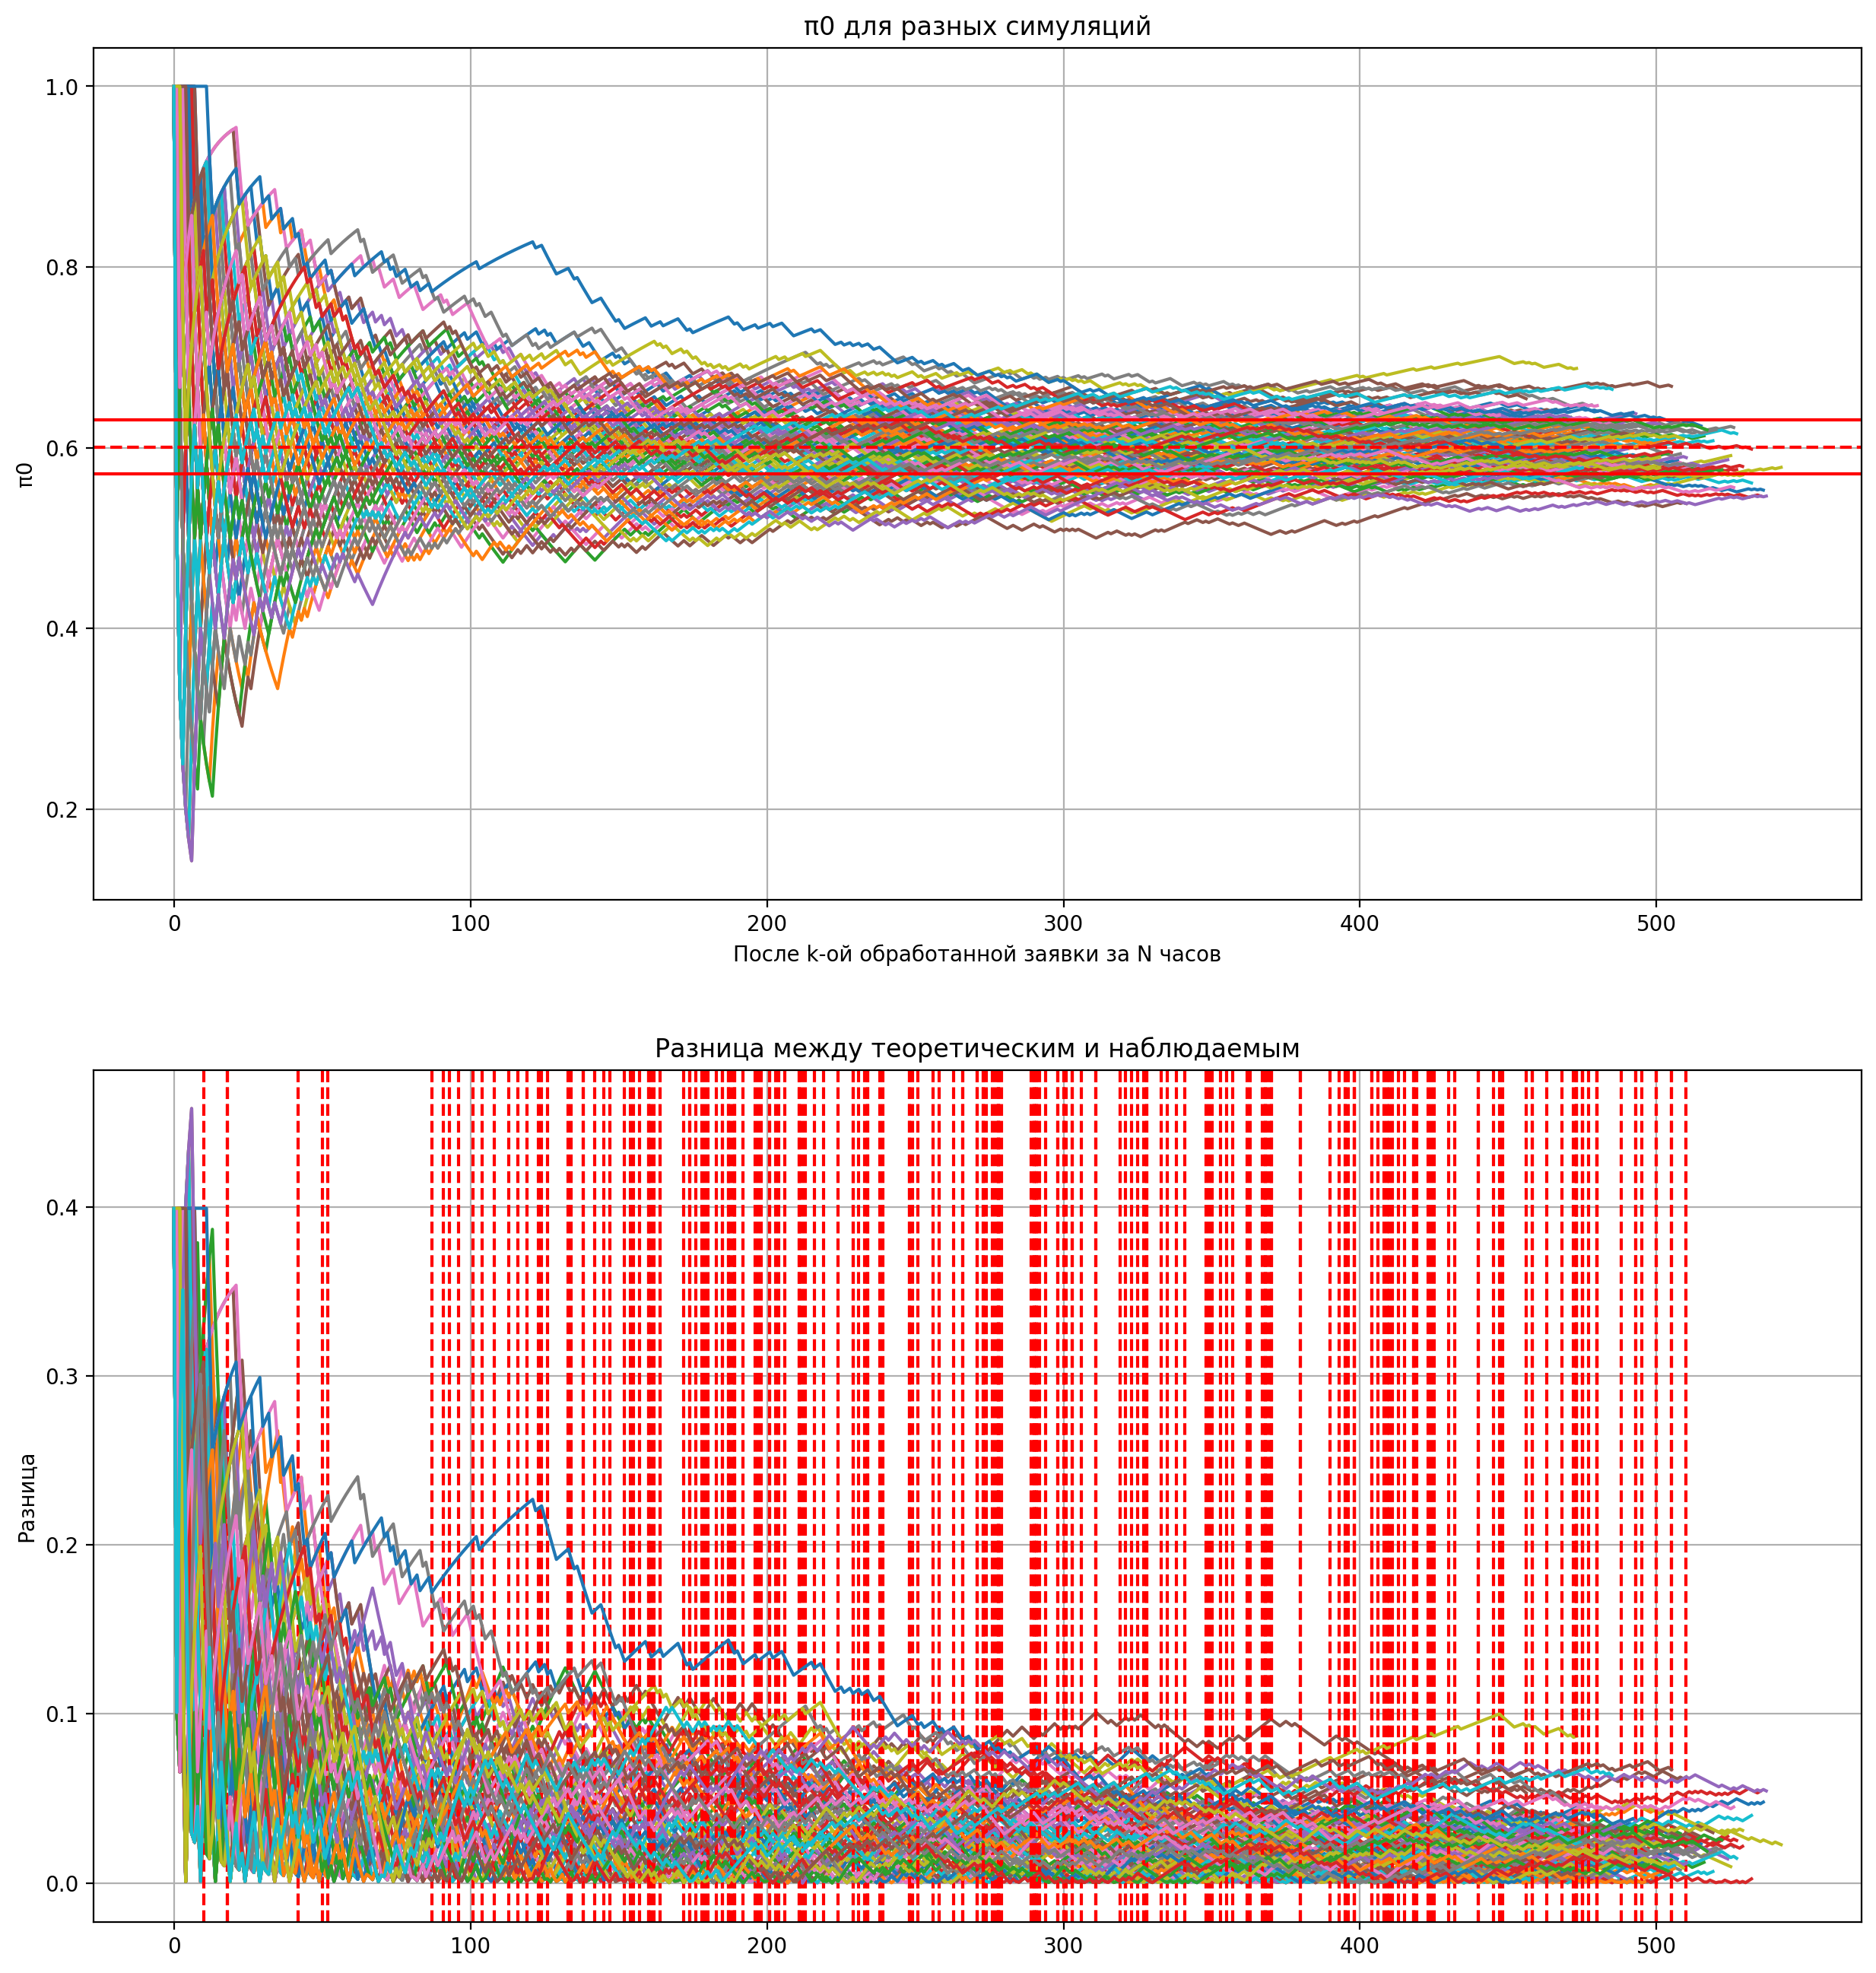

In [45]:
plt_func('π0', p_zero_hist_lst, 0.60093)


Определим достаточное количество экспериментов
Для этого проведем N=100 количество симуляций и рассчитаем среднее значение x0 и стандартное отклонение s0 для вывода необходимого количества симуляций при уровне значимости 0,05

N≥( 𝑍 (1-(𝛼/2)) ⋅ s_0 / (𝜖⋅x ̅ ₀) )^2

In [46]:
x_0 = np.mean([p_zero_hist_lst[i][-1] for i in range(len(p_zero_hist_lst))])
s_0 = np.std([p_zero_hist_lst[i][-1] for i in range(len(p_zero_hist_lst))])
print(x_0, s_0)

0.6037345629743991 0.02886705052475614


In [47]:
N = ((1.96 * s_0) / (0.05 * x_0)) ** 2
N

3.5130544415466063

In [50]:
prob_rej_hist_lst, queue_time_hist_lst, mean_total_spent_times_hist_lst, p_zero_hist_lst, p_immediate_lst = simulations(N=4, T=500)

Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка
Остановка


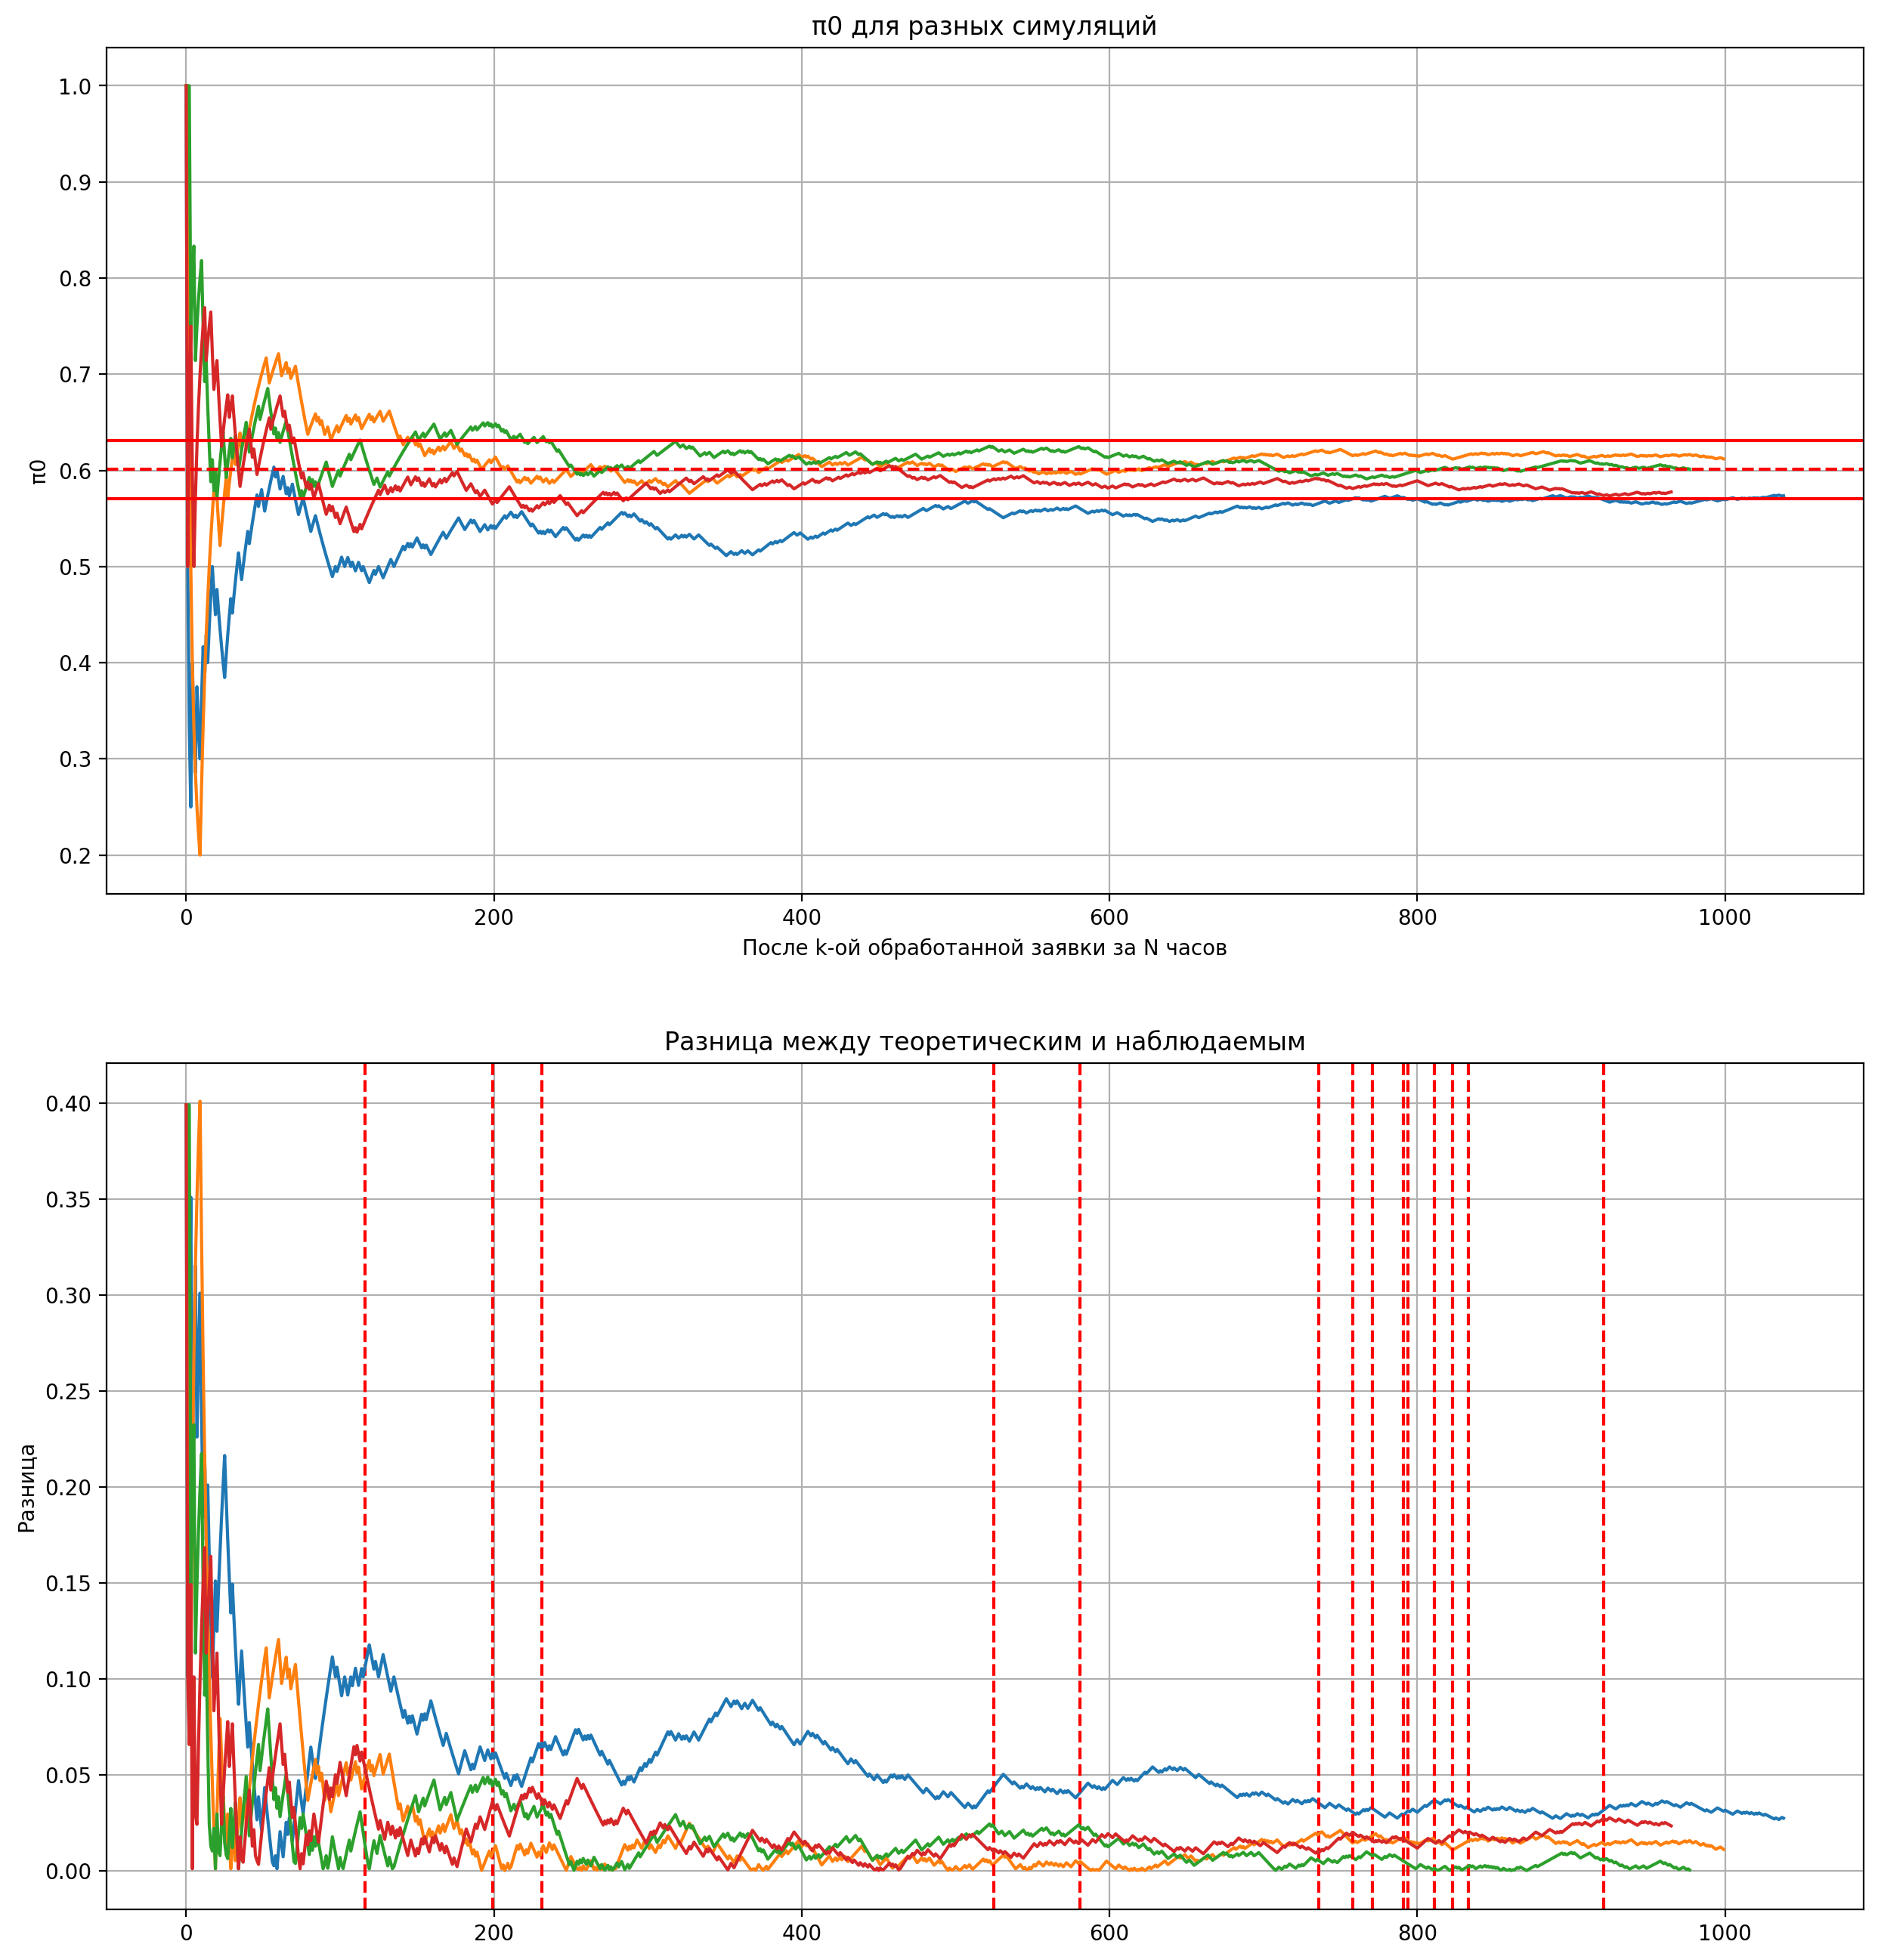

In [51]:
plt_func('π0', p_zero_hist_lst, 0.60093)
